# 1. Data Presentation


### Import essential libraries:

- for data manipulation and visualization: Numpy, Pandas, Seaborn, matplotlib

- for preprocessing and handling data imbalance: sklearn.preprocessing, sklearn.impute, imblearn.under_sampling

- for text processing: sklearn.feature_extraction.text

- for model building and evaluation: sklearn.model_selection, sklearn.metrics

- Machine learning models: sklearn.linear_model, sklearn.esemble, sklearn.svm, sklearn.neighbors, sklearn.naive_bayes

- Gradient boosting models: xgboost, lightgbm

- for building pipelines and transformations: sklearn.pipeline, sklearn.compose

- for statistical tests: scipy.stats

- Miscellaneous: warnings

In [1241]:
# === Core packages ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === Data preprocessing ===
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# === Data splitting and evaluation ===
from sklearn.model_selection import (
    train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV, cross_val_score
)
from scipy.stats import chi2_contingency, f_oneway
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    balanced_accuracy_score, matthews_corrcoef,
    classification_report, confusion_matrix,
    RocCurveDisplay, PrecisionRecallDisplay, make_scorer, 
    ConfusionMatrixDisplay, classification_report,
    confusion_matrix,
    roc_curve,
)

# === Models ===
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    StackingClassifier
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import RFE, SelectFromModel

# === Optional (class imbalance & optimization) ===
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from scipy.stats import randint, uniform, chi2_contingency

# === Utilities ===
import warnings
warnings.filterwarnings('ignore')

# Plot settings
plt.style.use('fivethirtyeight')
%matplotlib inline
pd.set_option('display.max_columns', 32)

### Loading the dataset

In [1242]:
df = pd.read_csv("bank_marketing/bank.csv", sep=";")

### First 5 rows of the dataset

In [1243]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Last 5 rows of the dataset

In [1244]:
df.tail()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41187,74,retired,married,professional.course,no,yes,no,cellular,nov,fri,239,3,999,1,failure,-1.1,94.767,-50.8,1.028,4963.6,no


### Checking how many columns (features + target) does the set contain

In [1245]:
len(df.columns)

21

### Checking what columns the dataset has

In [1246]:
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'euribor3m', 'nr.employed', 'y'],
      dtype='object')

### Checking the type of the colums

In [1247]:
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
num_cols = [c for c in df.columns if c not in cat_cols]

print('\nCategorical columns:', cat_cols)
print('Numerical columns:', num_cols)


Categorical columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'y']
Numerical columns: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


### Checking the shape (rows, columns) in DataFrame

In [1248]:
df.shape

(41188, 21)

### Checking the size (number of cells) in DataFrame

In [1249]:
df.size

864948

### An overview of the data types, missing values, percentage of missing values, and the number of unique values for each column in the DataFrame

In [1250]:
num_cols = df.select_dtypes(exclude='object').columns

data_info_num = pd.DataFrame({
    'Data Type': df[num_cols].dtypes,
    'Missing Values': df[num_cols].isnull().sum(),
    'Percentage Missing': (df[num_cols].isnull().sum() / len(df)) * 100,
    'Unique Values': df[num_cols].nunique()
})

data_info_num = data_info_num.sort_values(by='Missing Values', ascending=False)
data_info_num.style.format({'Percentage Missing': '{:.2f}%'})

,Data Type,Missing Values,Percentage Missing,Unique Values
age,int64,0,0.00%,78
duration,int64,0,0.00%,1544
campaign,int64,0,0.00%,42
pdays,int64,0,0.00%,27
previous,int64,0,0.00%,8
emp.var.rate,float64,0,0.00%,10
cons.price.idx,float64,0,0.00%,26
cons.conf.idx,float64,0,0.00%,26
euribor3m,float64,0,0.00%,316
nr.employed,float64,0,0.00%,11


In [1251]:
cat_cols = df.select_dtypes(include='object').columns

cat_info = pd.DataFrame({
    'Data Type': df[cat_cols].dtypes,
    'Unknown Count': [(df[c] == 'unknown').sum() for c in cat_cols],
    'Unknown (%)': [(df[c].eq('unknown').sum() / len(df)) * 100 for c in cat_cols],
    'Unique Values': [df[c].nunique() for c in cat_cols]
})

cat_info = cat_info.sort_values(by='Unknown Count', ascending=False)
cat_info.style.format({'Unknown (%)': '{:.2f}%'})

,Data Type,Unknown Count,Unknown (%),Unique Values
default,object,8597,20.87%,3
education,object,1731,4.20%,8
housing,object,990,2.40%,3
loan,object,990,2.40%,3
job,object,330,0.80%,12
marital,object,80,0.19%,4
contact,object,0,0.00%,2
month,object,0,0.00%,10
day_of_week,object,0,0.00%,5
poutcome,object,0,0.00%,3


### Check correlation between numerical variables

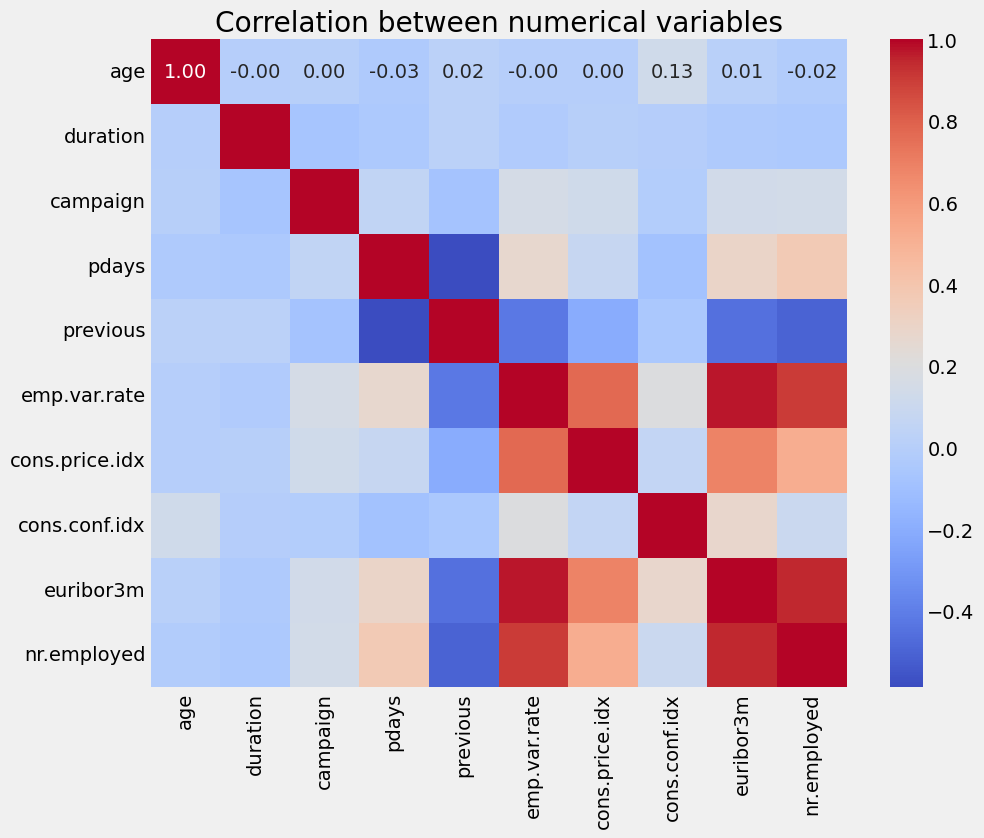

In [1252]:
# Select numerical columns
num_cols = df.select_dtypes(include=['int64','float64']).columns

# Calculate correlation matrix
corr = df[num_cols].corr()

# Show heatmap of correlations
plt.figure(figsize=(10,8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation between numerical variables")
plt.show()

### Check correlation between categorical variables

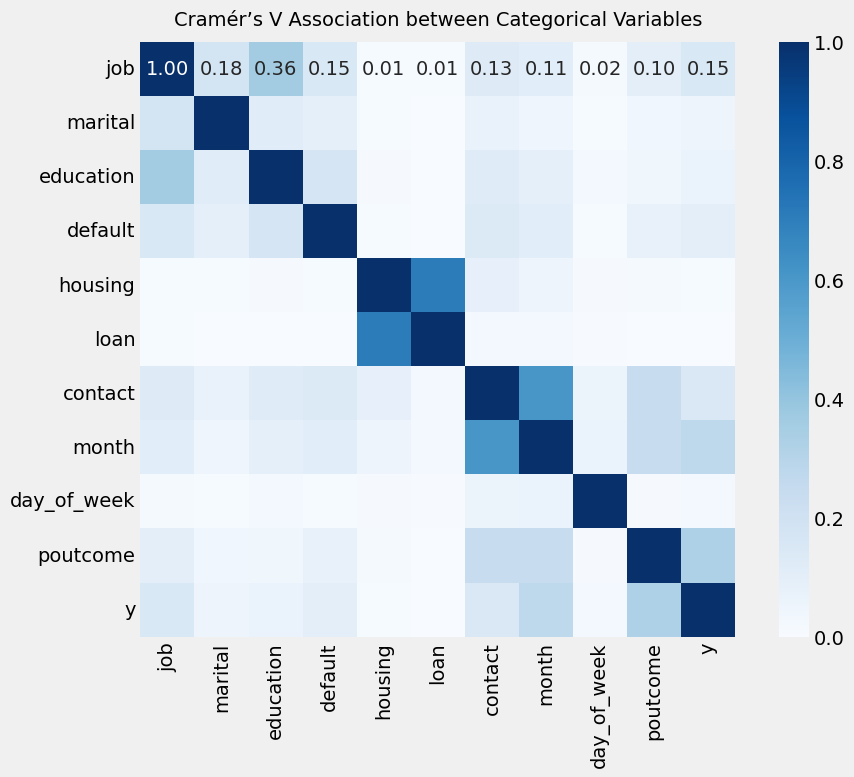

In [1253]:
def cramers_v(x, y):
    """Compute Cramér's V statistic for categorical-categorical association."""
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

cat_cols = df.select_dtypes(include='object').columns

cramers_results = pd.DataFrame(index=cat_cols, columns=cat_cols, dtype=float)

for c1 in cat_cols:
    for c2 in cat_cols:
        if c1 == c2:
            cramers_results.loc[c1, c2] = 1.0
        else:
            cramers_results.loc[c1, c2] = cramers_v(df[c1], df[c2])

plt.figure(figsize=(10, 8))
sns.heatmap(cramers_results, annot=True, cmap='Blues', fmt=".2f", square=True)
plt.title("Cramér’s V Association between Categorical Variables", fontsize=14, pad=12)
plt.tight_layout()
plt.show()

--------------------
## Descriptive statistics
--------------------

In [1254]:
df.describe(include = 'number').T

,count,mean,std,min,25%,50%,75%,max
age,41188.0,40.024060,10.421250,17.000,32.000,38.000,47.000,98.000
duration,41188.0,258.285010,259.279249,0.000,102.000,180.000,319.000,4918.000
campaign,41188.0,2.567593,2.770014,1.000,1.000,2.000,3.000,56.000
pdays,41188.0,962.475454,186.910907,0.000,999.000,999.000,999.000,999.000
previous,41188.0,0.172963,0.494901,0.000,0.000,0.000,0.000,7.000
emp.var.rate,41188.0,0.081886,1.570960,-3.400,-1.800,1.100,1.400,1.400
cons.price.idx,41188.0,93.575664,0.578840,92.201,93.075,93.749,93.994,94.767
cons.conf.idx,41188.0,-40.502600,4.628198,-50.800,-42.700,-41.800,-36.400,-26.900
euribor3m,41188.0,3.621291,1.734447,0.634,1.344,4.857,4.961,5.045
nr.employed,41188.0,5167.035911,72.251528,4963.600,5099.100,5191.000,5228.100,5228.100


In [1255]:
df.describe(include = 'object').T 

,count,unique,top,freq
job,41188,12,admin.,10422
marital,41188,4,married,24928
education,41188,8,university.degree,12168
default,41188,3,no,32588
housing,41188,3,yes,21576
loan,41188,3,no,33950
contact,41188,2,cellular,26144
month,41188,10,may,13769
day_of_week,41188,5,thu,8623
poutcome,41188,3,nonexistent,35563


### Class balance plot

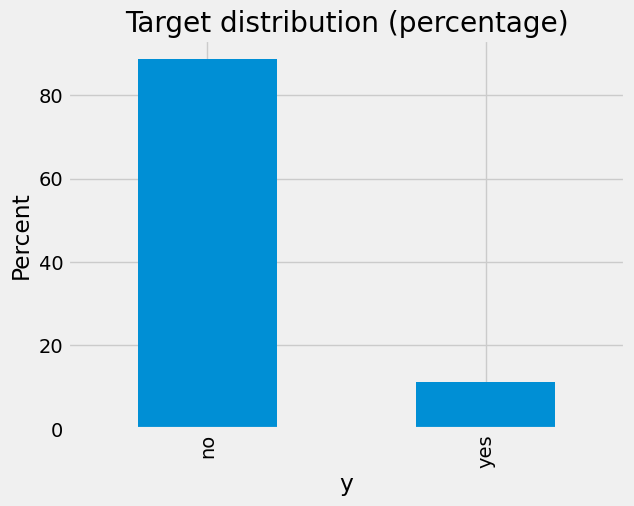

In [1256]:
fig = plt.figure()
(df['y'].value_counts(normalize=True).sort_index()*100).plot(kind='bar')
plt.title('Target distribution (percentage)')
plt.ylabel('Percent')
plt.xlabel('y')
plt.show()

-------------------
# Data cleaning, feature selection
-------------------

### Dropping duplicated rows

In [1257]:
df.drop_duplicates(inplace=True)
df.size

864696

### Columns dropping based on the set description

The columns **`y`** (target variable) and **`duration`** will be removed from the modeling dataset to avoid data leakage,  
but both will be **saved separately** for later analysis and evaluation at the end of the project.

### Dropping columns with high correlation

In [1258]:
#to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
#print("Features muito correlacionadas (remover):", to_drop)
#Features muito correlacionadas (remover): ['euribor3m', 'nr.employed']
#X = X.drop(columns=to_drop) 
 
#df.drop(columns=['pdays', 'cons.price.idx', 'cons.conf.idx', 'nr.employed'], inplace=True)
df.drop(columns=['pdays', 'nr.employed', 'euribor3m'], inplace=True)
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'y'],
      dtype='object')

### Handling 'unknown' values

For categorical variables, we treated missing or `'unknown'` values as follows:  
- The variables **`education`** and **`default`** were **kept and modeled**, since the `'unknown'` category may carry useful information for prediction.  
- For **`job`**, **`marital`**, **`housing`**, and **`loan`**, we **dropped the rows** containing `'unknown'` values because their occurrence was very low (less than 3% of the dataset).  
This ensures data consistency while avoiding potential bias due to extremely rare missing categories.

In [1259]:
df = df[df['housing'] != 'unknown']
df = df[df['loan'] != 'unknown']
df = df[df['job'] != 'unknown']
df = df[df['marital'] != 'unknown']
df['education'] = df['education'].fillna('unknown')
df['default'] = df['default'].fillna('unknown')

cat_cols = df.select_dtypes(include='object').columns
cat_info = pd.DataFrame({
    'Data Type': df[cat_cols].dtypes,
    'Unknown Count': [(df[c] == 'unknown').sum() for c in cat_cols],
    'Unknown (%)': [(df[c].eq('unknown').sum() / len(df)) * 100 for c in cat_cols],
    'Unique Values': [df[c].nunique() for c in cat_cols]
})

cat_info = cat_info.sort_values(by='Unknown Count', ascending=False)
cat_info.style.format({'Unknown (%)': '{:.2f}%'})


,Data Type,Unknown Count,Unknown (%),Unique Values
default,object,8212,20.64%,3
education,object,1557,3.91%,8
job,object,0,0.00%,11
marital,object,0,0.00%,3
housing,object,0,0.00%,2
loan,object,0,0.00%,2
contact,object,0,0.00%,2
month,object,0,0.00%,10
day_of_week,object,0,0.00%,5
poutcome,object,0,0.00%,3


### Cross tablulation between categorical variable and the goal attribute

In [1260]:
for predictor in cat_cols:
    print(pd.crosstab(index=df[predictor], columns=df['y']),'\n')

y                no   yes
job                      
admin.         8858  1320
blue-collar    8381   619
entrepreneur   1297   120
housemaid       925   103
management     2526   324
retired        1246   423
self-employed  1229   147
services       3544   316
student         587   264
technician     5873   707
unemployed      839   143 

y            no   yes
marital              
divorced   4012   465
married   21648  2455
single     9645  1566 

y                       no   yes
education                       
basic.4y              3590   412
basic.6y              2023   180
basic.9y              5399   457
high.school           8234  1007
illiterate              14     4
professional.course   4519   578
university.degree    10198  1619
unknown               1328   229 

y           no   yes
default             
no       27515  4061
unknown   7787   425
yes          3     0 

y           no   yes
housing             
no       16417  2003
yes      18888  2483 

y        no   yes
loan 

### Categorical variable encoding

The categorical variables are converted into numeric form:
- **`education`** and **`month`** are ordinal, so they are mapped to ordered numeric codes.  
- Other categorical variables are nominal and are transformed using **one-hot encoding** (`pd.get_dummies()`), creating binary columns.  
- The target **`y`** is encoded with `LabelEncoder` (`no` = 0, `yes` = 1).

This ensures all variables are numeric and ready for model training.

In [1261]:
edu_order = ['illiterate', 'basic.4y', 'basic.6y', 'basic.9y',
              'high.school', 'professional.course', 'university.degree', 'unknown']
month_order = ['jan','feb','mar','apr','may','jun','jul','aug','sep','oct','nov','dec']

df['education'] = pd.Categorical(df['education'], categories=edu_order, ordered=True).codes
df['month'] = pd.Categorical(df['month'], categories=month_order, ordered=True).codes

nominal_cols = ['job', 'marital', 'default', 'housing', 'loan',
                'contact', 'day_of_week', 'poutcome']
dfML = df.copy()
dfML = pd.get_dummies(dfML, columns=nominal_cols, drop_first=True)


le = LabelEncoder()
df['y'] = le.fit_transform(df['y'])
dfML['y'] = le.fit_transform(dfML['y'])
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'previous',
       'poutcome', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'y'],
      dtype='object')

### Scale numeric variables

In [1262]:
num_cols_scaled = ['age','campaign','previous','emp.var.rate','cons.price.idx',
                   'cons.conf.idx']

scaler = StandardScaler()
df[num_cols_scaled] = scaler.fit_transform(df[num_cols_scaled])

### Columns dropping based on the set description

The column **`duration`** will be removed from the modeling dataset to avoid data leakage,  
but will be **saved separately** for later analysis and evaluation at the end of the project.

In [1263]:
duration = df['duration'].copy()
df=df.drop(columns=['duration'])
df.columns

Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'campaign', 'previous', 'poutcome',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'y'],
      dtype='object')

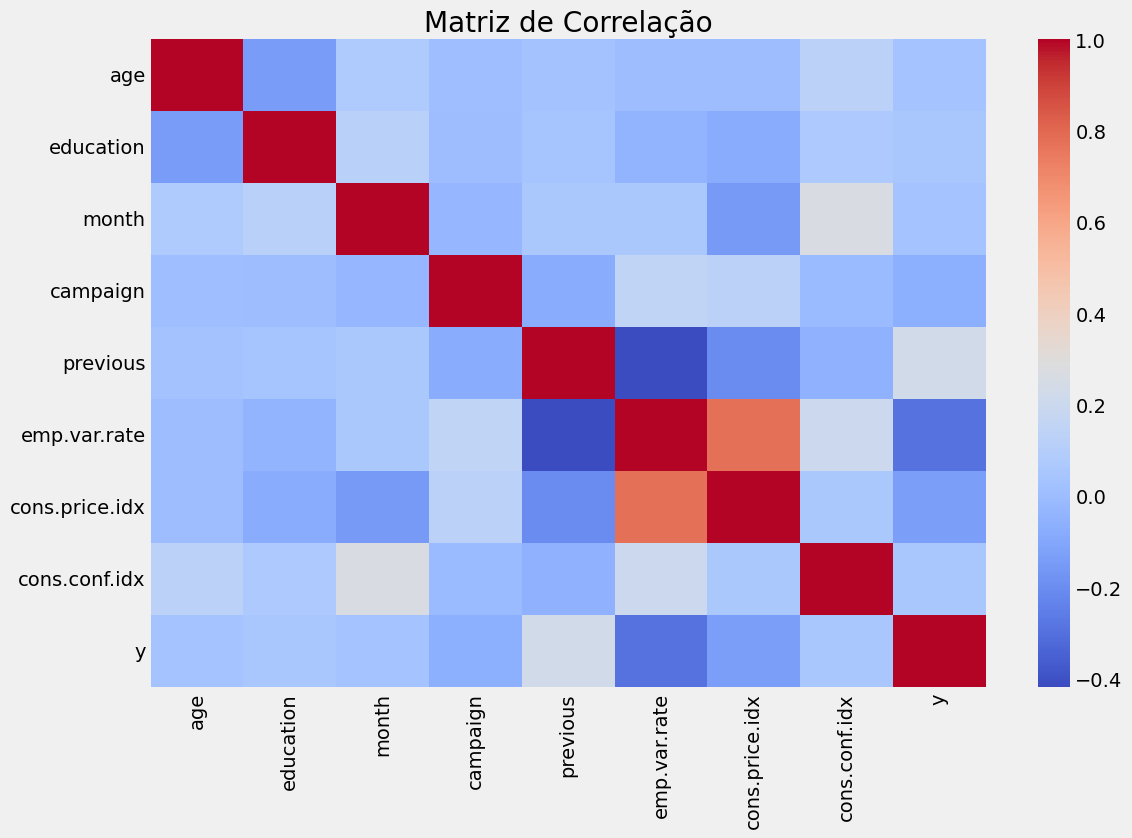

In [1264]:
corr = df.corr(numeric_only=True)

plt.figure(figsize=(12,8))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Matriz de Correlação")
plt.show()

### Correlation between Features and Target (y)

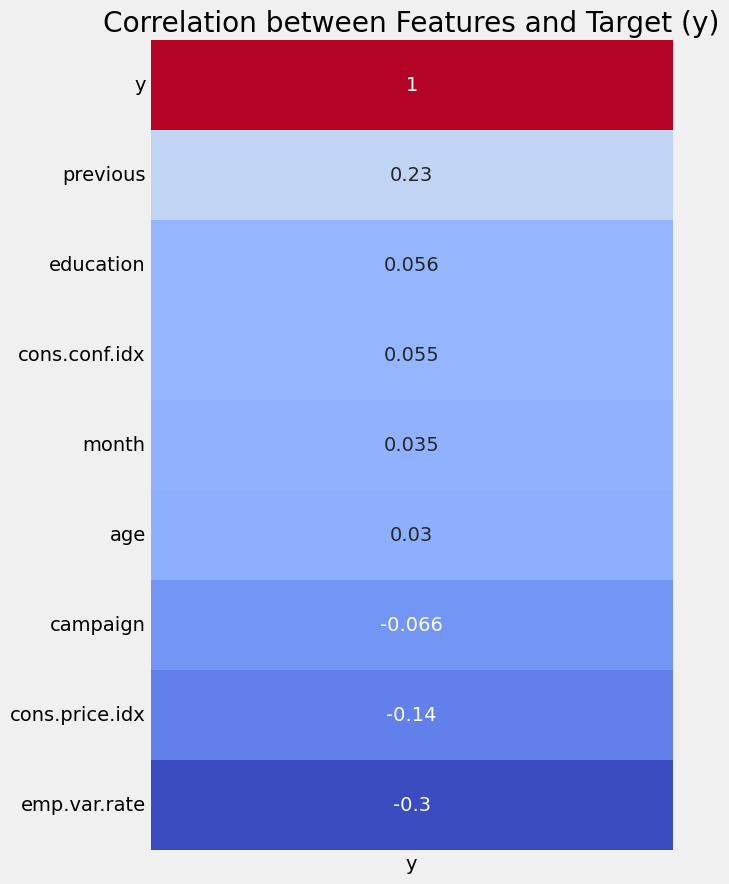

In [1265]:
df_temp = df.drop(columns=['y']).copy()
df_temp['y'] = df['y']

corr_with_target = df_temp.corr(numeric_only=True)['y'].sort_values(ascending=False)

plt.figure(figsize=(6,10))
sns.heatmap(corr_with_target.to_frame(), annot=True, cmap="coolwarm", cbar=False)
plt.title("Correlation between Features and Target (y)")
plt.show()

### Random Forest Feature Importance Plot

Display the top 15 most influential features in the Random Forest model using a horizontal bar chart.
This helps visualize which variables have the greatest predictive power.

In [1266]:
# rf = RandomForestClassifier(random_state=42)
# rf.fit(df_temp, df['y'])

# importances = pd.Series(rf.feature_importances_, index=df_temp.columns)
# importances = importances.sort_values(ascending=False)

# print("Top 15 features (Random Forest):")
# print(importances.head(15))

# import matplotlib.pyplot as plt
# plt.figure(figsize=(10,6))
# importances.head(15).plot(kind='barh')
# plt.gca().invert_yaxis()
# plt.title("Feature Importance - Random Forest")
# plt.xlabel("Importance")
# plt.show()

###

### Train/Test Split and Cross-Validation

Experiment with different train/test splits (e.g., 70/30, 80/20, 90/10) to assess model robustness.
For a more reliable evaluation, use Stratified K-Fold Cross-Validation, which averages results across multiple partitions.

In [1267]:
X = df.drop(columns=['y'])
y = df['y']


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Combine features and target for train/test (useful for Chi-Square or EDA)
train_df = X_train.copy()
train_df['y'] = y_train

test_df = X_test.copy()
test_df['y'] = y_test


X = dfML.drop(columns=['y'])
y = dfML['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Combine features and target for modelling
train_dfML = X_train.copy()
train_dfML['y'] = y_train

test_dfML = X_test.copy()
test_dfML['y'] = y_test

### Applying SMOTE to Balance the Training Data

Use the Synthetic Minority Over-sampling Technique (SMOTE) to generate synthetic samples of the minority class, ensuring a balanced training dataset and improving model fairness.

In [1268]:
X_train = train_dfML.drop(columns=['y']).copy()
y_train = train_dfML['y']
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\nOriginal train shape:", X_train.shape)
print("Resampled train shape:", X_train_res.shape)


Original train shape: (31832, 32)
Resampled train shape: (56486, 32)


In [1269]:
model = LogisticRegression()
rfe = RFE(model, n_features_to_select=10)
rfe.fit(X, y)
print("Features selected:", X.columns[rfe.support_])

Features selected: Index(['previous', 'emp.var.rate', 'job_blue-collar', 'job_retired',
       'job_services', 'job_student', 'default_unknown', 'contact_telephone',
       'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')


In [1270]:
def FunctionChisq(inpData, TargetVariable, CategoricalVariablesList):


    FiltPredictors = []

    for predictor in CategoricalVariablesList:
        CrossTabResult = pd.crosstab(index=inpData[TargetVariable],
                                     columns=inpData[predictor])
        ChiSqResult = chi2_contingency(CrossTabResult)
        p_value = ChiSqResult[1]

        if p_value < 0.05:
            print(f"{predictor} IS correlated with {TargetVariable} | P-Value: {p_value:.4f}")
        else:
            print(f"{predictor} is NOT correlated with {TargetVariable} | P-Value: {p_value:.4f}")
            FiltPredictors.append(predictor)
            
    return FiltPredictors

In [1271]:
categorical_vars = ['job', 'marital', 'education', 'default', 'housing',
                    'loan', 'contact', 'month', 'day_of_week', 'poutcome']

insignificant_vars = FunctionChisq(inpData=train_df, TargetVariable='y', CategoricalVariablesList=categorical_vars)

job IS correlated with y | P-Value: 0.0000
marital IS correlated with y | P-Value: 0.0000
education IS correlated with y | P-Value: 0.0000
default IS correlated with y | P-Value: 0.0000
housing IS correlated with y | P-Value: 0.0061
loan is NOT correlated with y | P-Value: 0.4043
contact IS correlated with y | P-Value: 0.0000
month IS correlated with y | P-Value: 0.0000
day_of_week IS correlated with y | P-Value: 0.0001
poutcome IS correlated with y | P-Value: 0.0000


### Continuous vs Categorical using ANOVA test

- **Assumption (H₀):** There is **no relationship** between the continuous predictor and the target variable.  
  In other words, the mean of the numeric variable is **the same across both classes** of the target (`y`).

- **Alternative (H₁):** There **is a relationship**, meaning that the mean values differ significantly between the groups of `y`.

The ANOVA test evaluates the probability that the null hypothesis (H₀) is true.  
If the **p-value < 0.05**, we reject H₀ and conclude that the variable is **significantly correlated** with the target.  
If the **p-value ≥ 0.05**, we fail to reject H₀, meaning there is **no significant difference** between the groups.

In [1272]:
def FunctionAnova(inpData, TargetVariable, ContinuousPredictorList):
    # Lista para guardar variáveis não significativas
    FiltPredictors = []

    print('##### ANOVA Results #####\n')
    for predictor in ContinuousPredictorList:
        try:
            # Cria listas dos valores da variável para cada categoria de y
            CategoryGroupLists = inpData.groupby(TargetVariable)[predictor].apply(list)
            AnovaResults = f_oneway(*CategoryGroupLists)

            p_value = AnovaResults[1]

            # Teste de significância
            if p_value < 0.05:
                print(f"{predictor} IS correlated with {TargetVariable} | P-Value: {p_value:.4f}")
            else:
                print(f"{predictor} is NOT correlated with {TargetVariable} | P-Value: {p_value:.4f}")
                FiltPredictors.append(predictor)
        except Exception as e:
            print(f"⚠️ Could not test {predictor}: {e}")

    return FiltPredictors

In [1273]:
continuous_vars = [
    'age', 'campaign', 'previous', 'emp.var.rate',
    'cons.price.idx', 'cons.conf.idx'
]
insignificant_continuous_vars = FunctionAnova(inpData=train_df, TargetVariable='y', ContinuousPredictorList=continuous_vars)

##### ANOVA Results #####

age IS correlated with y | P-Value: 0.0000
campaign IS correlated with y | P-Value: 0.0000
previous IS correlated with y | P-Value: 0.0000
emp.var.rate IS correlated with y | P-Value: 0.0000
cons.price.idx IS correlated with y | P-Value: 0.0000
cons.conf.idx IS correlated with y | P-Value: 0.0000


In [1274]:


def lasso_regularization(df):

    X = df.iloc[:,:-1].copy()          
    y = df.iloc[:,-1].copy() 
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

    scaler = StandardScaler()
    scaler.fit(X_train)

    # fit a Logistic Regression model and feature selection altogether 
    # select the Lasso (l1) penalty.
    # The selectFromModel class from sklearn, selects the features which coefficients are non-zero

    sel_ = SelectFromModel(LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=10))

    sel_.fit(scaler.transform(X_train), y_train)

    # make a list with the selected features
    selected_feat = X_train.columns[(sel_.get_support())]
    
    print("Number of features which coefficient was shrank to zero: ", np.sum(sel_.estimator_.coef_ == 0))
    # identify the removed features like this:
    removed_feats = X_train.columns[(sel_.estimator_.coef_ == 0).ravel().tolist()]
    print('Removed features by Lasso: ',removed_feats) 

    return X_train.columns[(sel_.estimator_.coef_ != 0).ravel().tolist()]

In [1275]:
selected_features = lasso_regularization(train_dfML)
print("Selected features:", selected_features)

Number of features which coefficient was shrank to zero:  2
Removed features by Lasso:  Index(['job_housemaid', 'marital_married'], dtype='object')
Selected features: Index(['age', 'education', 'month', 'duration', 'campaign', 'previous',
       'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'job_blue-collar',
       'job_entrepreneur', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student', 'job_technician',
       'job_unemployed', 'marital_single', 'default_unknown', 'default_yes',
       'housing_yes', 'loan_yes', 'contact_telephone', 'day_of_week_mon',
       'day_of_week_thu', 'day_of_week_tue', 'day_of_week_wed',
       'poutcome_nonexistent', 'poutcome_success'],
      dtype='object')


In [ ]:
selected_categorical = [var for var in categorical_vars if var not in insignificant_vars]

selected_continuous = [var for var in continuous_vars if var not in insignificant_continuous_vars]

selected_all = list(set(list(selected_categorical) + 
                        list(selected_continuous) + 
                        list(selected_features)))

print(f"Total features selected: {len(selected_all)}")
print("Selected variables:\n", selected_all)
# --- Create dfFS safely, including dummy-encoded columns ---
dfFS_cols = []

for col in selected_all:
    # procura todas as colunas no dfML que contenham o nome da variável original
    matched = [c for c in dfML.columns if col in c]
    dfFS_cols.extend(matched)

# adiciona a variável alvo 'y'
dfFS_cols = list(set(dfFS_cols + ['y']))

# cria o novo dataframe
dfFS = dfML[dfFS_cols].copy()

print(f"\ndfFS created successfully with {len(dfFS.columns)-1} features.")
print("Shape:", dfFS.shape)

Total features selected: 37
Selected variables:
 ['job_unemployed', 'contact', 'contact_telephone', 'job_blue-collar', 'job_technician', 'housing', 'poutcome', 'default_unknown', 'housing_yes', 'job_entrepreneur', 'day_of_week_thu', 'job', 'job_retired', 'emp.var.rate', 'marital_single', 'loan_yes', 'day_of_week_tue', 'default', 'marital', 'previous', 'age', 'cons.conf.idx', 'cons.price.idx', 'job_management', 'campaign', 'job_services', 'day_of_week_mon', 'poutcome_nonexistent', 'job_student', 'poutcome_success', 'default_yes', 'month', 'day_of_week_wed', 'education', 'job_self-employed', 'day_of_week', 'duration']

✅ dfFS created successfully with 32 features.
Shape: (39791, 33)


### Model Evaluation Function

Evaluate a classifier’s performance using precision, recall, F1-score, AUC, confusion matrix, and ROC curve.
This unified function allows consistent comparison across multiple models.

In [1277]:
# def evaluate_model(model, X_train, y_train, X_test, y_test):
#     model.fit(X_train, y_train)
#     y_pred = model.predict(X_test)
#     y_proba = model.predict_proba(X_test)[:,1]
    
#     print(classification_report(y_test, y_pred))
#     print("AUC:", roc_auc_score(y_test, y_proba))
    
#     cm = confusion_matrix(y_test, y_pred)
#     ConfusionMatrixDisplay(cm).plot()
#     plt.show()
    
#     fpr, tpr, _ = roc_curve(y_test, y_proba)
#     plt.plot(fpr, tpr, label=model.__class__.__name__)
#     plt.plot([0,1],[0,1],'k--')
#     plt.xlabel('False Positive Rate')
#     plt.ylabel('True Positive Rate')
#     plt.title('ROC Curve')
#     plt.legend()
#     plt.show()

def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:,1]
    
    print(classification_report(y_test, y_pred))
    print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
    print("Matthews Corr. Coefficient (MCC):", matthews_corrcoef(y_test, y_pred))
    print("AUC:", roc_auc_score(y_test, y_proba))
    
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot(cmap='Blues')
    plt.show()
    
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f"{model.__class__.__name__} (AUC={roc_auc_score(y_test, y_proba):.3f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.show()

### Model Training and Evaluation
Train and evaluate multiple models (Random Forest and Logistic Regression) using the same balanced training data.
Compare metrics such as Precision, Recall, F1, ROC-AUC, and MCC to identify the most effective classifier.


--- RANDOM FOREST ---
ROC-AUC médio (5-fold CV): 0.9932
Desvio padrão: 0.0004

--- LOGISTIC REGRESSION ---
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      7062
           1       0.50      0.61      0.55       897

    accuracy                           0.89      7959
   macro avg       0.72      0.77      0.74      7959
weighted avg       0.90      0.89      0.89      7959

Balanced Accuracy: 0.7655396208829772
Matthews Corr. Coefficient (MCC): 0.4860671197342405
AUC: 0.8866759679437454


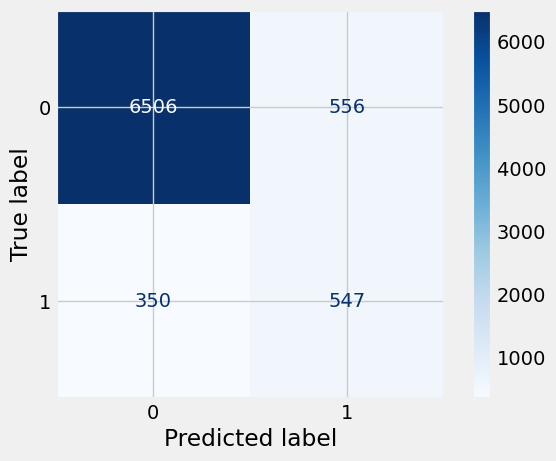

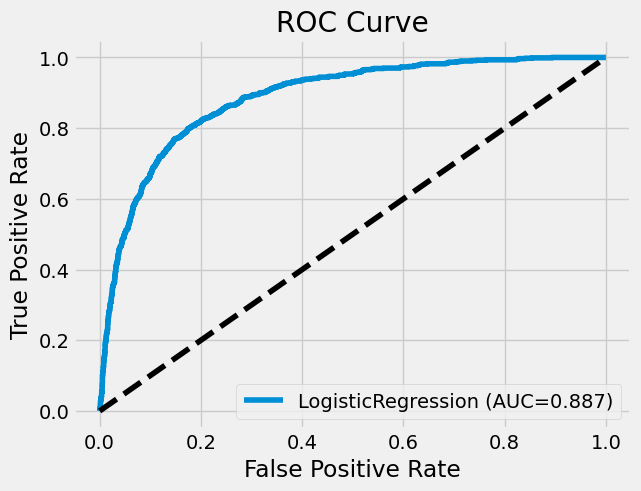


--- DECISION TREE ---
              precision    recall  f1-score   support

           0       0.94      0.93      0.93      7062
           1       0.49      0.57      0.53       897

    accuracy                           0.89      7959
   macro avg       0.72      0.75      0.73      7959
weighted avg       0.89      0.89      0.89      7959

Balanced Accuracy: 0.7454379225000923
Matthews Corr. Coefficient (MCC): 0.46208226202114355
AUC: 0.7454379225000923


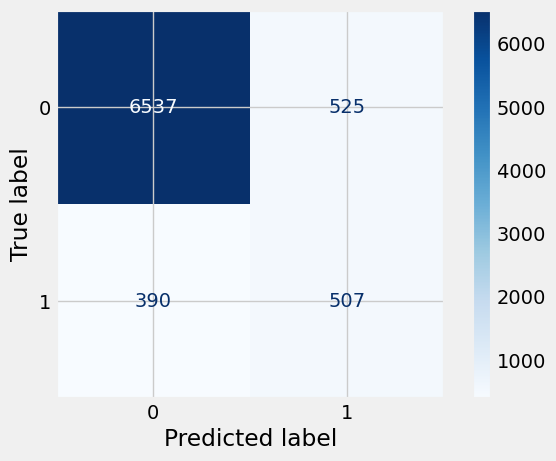

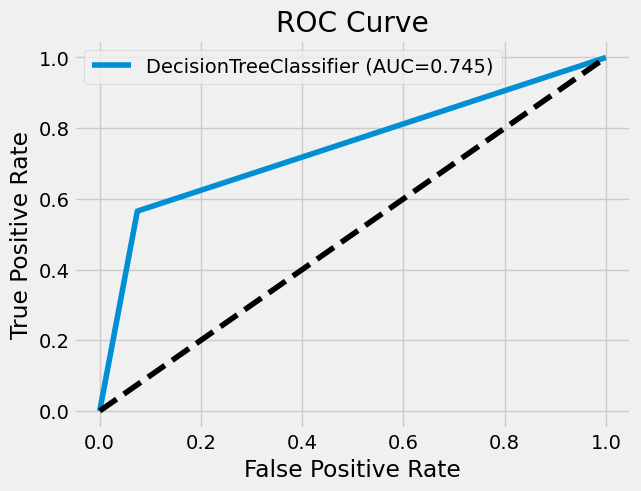


--- K-NEAREST NEIGHBOURS (KNN) ---
              precision    recall  f1-score   support

           0       0.96      0.87      0.91      7062
           1       0.42      0.73      0.53       897

    accuracy                           0.85      7959
   macro avg       0.69      0.80      0.72      7959
weighted avg       0.90      0.85      0.87      7959

Balanced Accuracy: 0.801295785346984
Matthews Corr. Coefficient (MCC): 0.4784100734331711
AUC: 0.8639053618736674


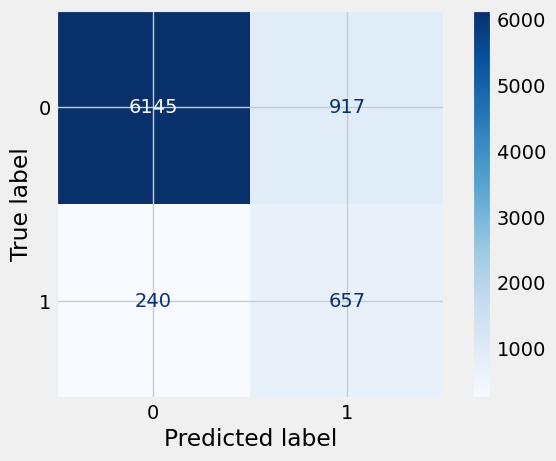

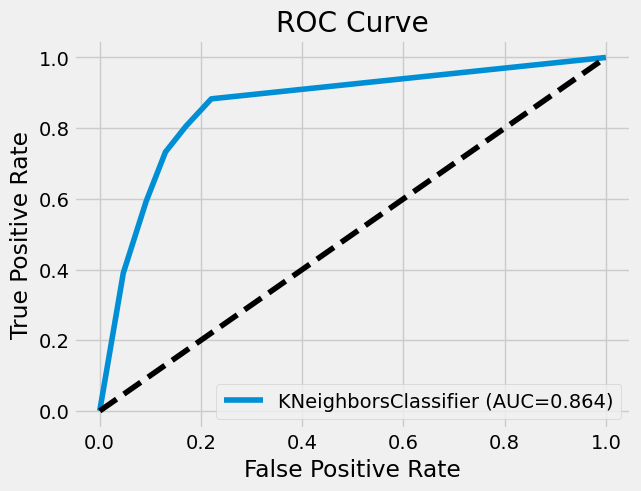


--- NAIVE BAYES ---
              precision    recall  f1-score   support

           0       0.94      0.84      0.89      7062
           1       0.31      0.56      0.40       897

    accuracy                           0.81      7959
   macro avg       0.63      0.70      0.65      7959
weighted avg       0.87      0.81      0.83      7959

Balanced Accuracy: 0.7038156547502341
Matthews Corr. Coefficient (MCC): 0.32081996193521917
AUC: 0.8106179003172096


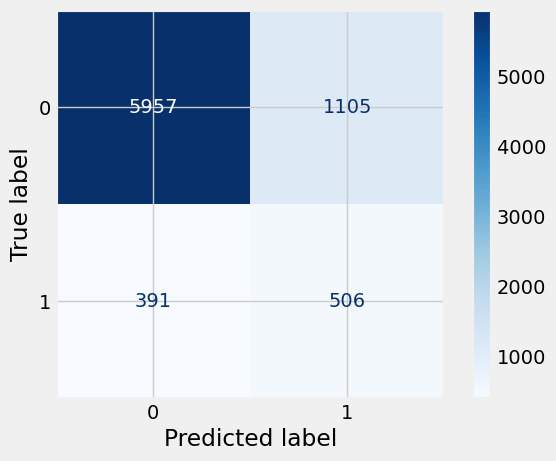

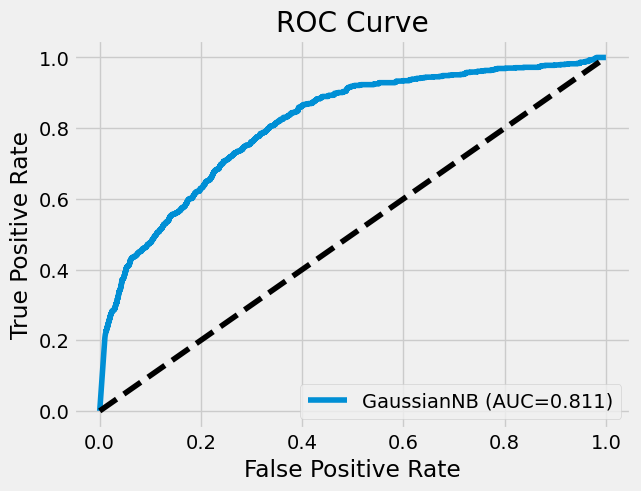


--- XGBOOST ---
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      7062
           1       0.60      0.61      0.60       897

    accuracy                           0.91      7959
   macro avg       0.77      0.78      0.78      7959
weighted avg       0.91      0.91      0.91      7959

Balanced Accuracy: 0.7793369098732772
Matthews Corr. Coefficient (MCC): 0.5533319149977213
AUC: 0.9443163387698131


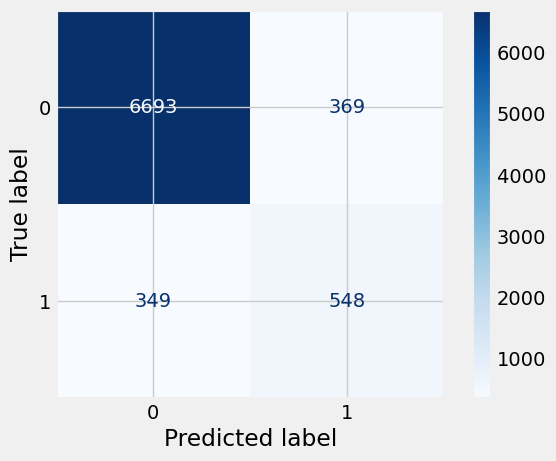

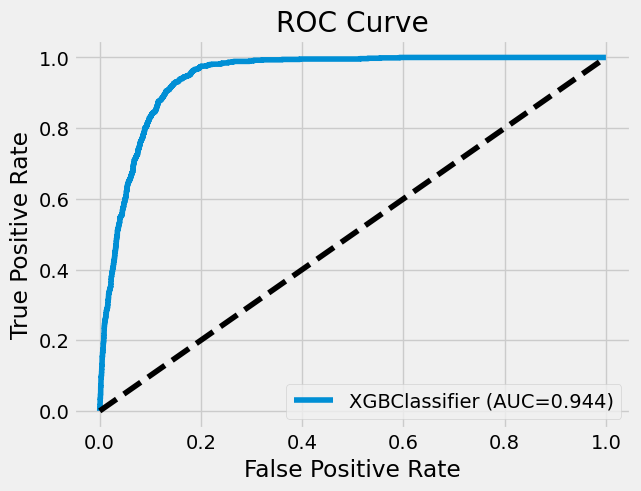


--- LIGHTGBM ---
[LightGBM] [Info] Number of positive: 28243, number of negative: 28243
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002452 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1203
[LightGBM] [Info] Number of data points in the train set: 56486, number of used features: 31
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      7062
           1       0.59      0.59      0.59       897

    accuracy                           0.91      7959
   macro avg       0.77      0.77      0.77      7959
weighted avg       0.91      0.91      0.91      7959

Balanced Accuracy: 0.7698698768385888
Matthews Corr. Coefficient (MCC): 0.5413240996290635
AUC: 0.9450018580453363


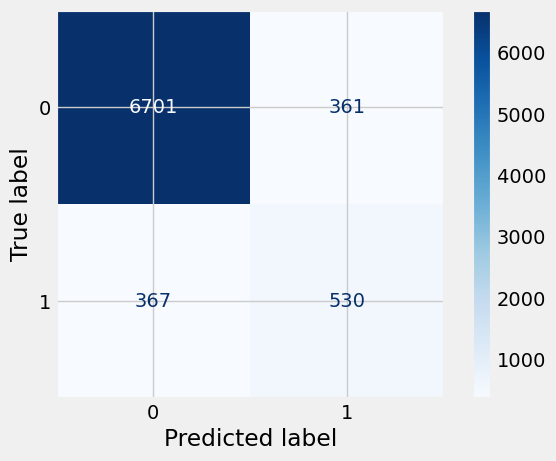

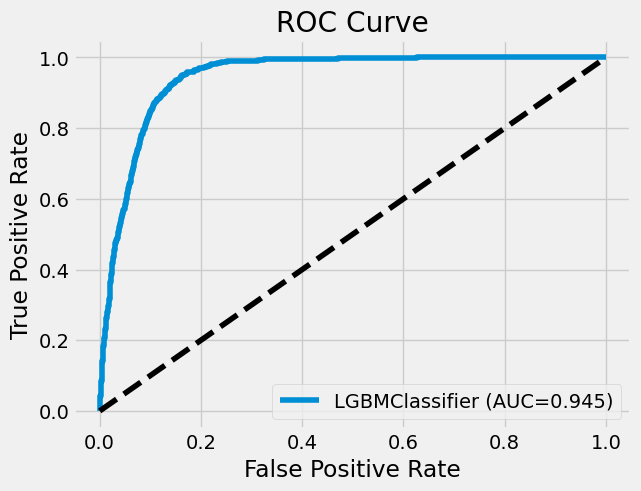


--- MLP (Neural Network) ---
              precision    recall  f1-score   support

           0       0.96      0.89      0.93      7062
           1       0.46      0.73      0.56       897

    accuracy                           0.87      7959
   macro avg       0.71      0.81      0.74      7959
weighted avg       0.91      0.87      0.88      7959

Balanced Accuracy: 0.8091907415353169
Matthews Corr. Coefficient (MCC): 0.5097784588993162
AUC: 0.913329683545043


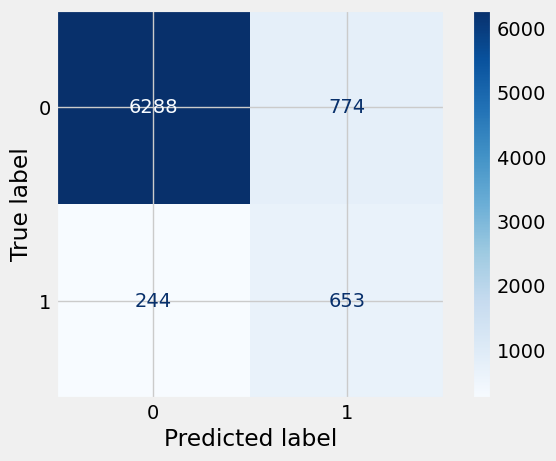

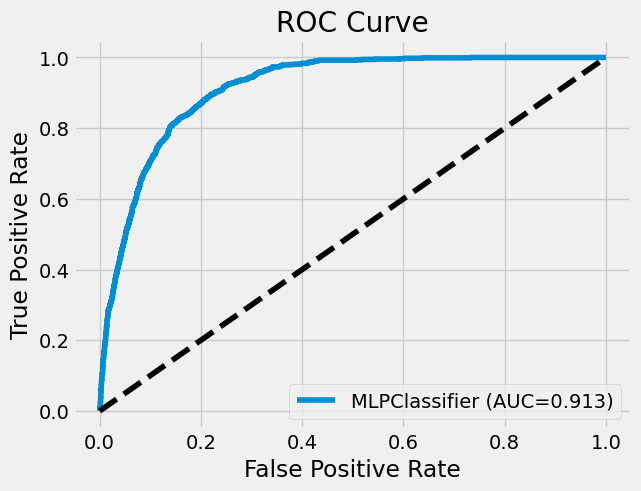

XGB | ROC-AUC CV: 0.9923 ± 0.0004
LGBM | ROC-AUC CV: 0.9926 ± 0.0004
MLP | ROC-AUC CV: 0.9738 ± 0.0025


In [1278]:
print("\n--- RANDOM FOREST ---")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rf_model = RandomForestClassifier(random_state=42)
scores = cross_val_score(rf_model, X_train_res, y_train_res, cv=cv, scoring='roc_auc')

print("ROC-AUC médio (5-fold CV):", round(scores.mean(), 4))
print("Desvio padrão:", round(scores.std(), 4))


print("\n--- LOGISTIC REGRESSION ---")
lr_model = LogisticRegression(max_iter=1000)
evaluate_model(lr_model, X_train_res, y_train_res, X_test, y_test)

print("\n--- DECISION TREE ---")
dt_model = DecisionTreeClassifier(
    criterion='gini', 
    max_depth=None, 
    min_samples_split=2, 
    random_state=42
)
evaluate_model(dt_model, X_train_res, y_train_res, X_test, y_test)

print("\n--- K-NEAREST NEIGHBOURS (KNN) ---")
knn_model = KNeighborsClassifier(
    n_neighbors=5,  
    metric='minkowski', 
    p=2             
)
evaluate_model(knn_model, X_train_res, y_train_res, X_test, y_test)

print("\n--- NAIVE BAYES ---")
nb_model = GaussianNB()
evaluate_model(nb_model, X_train_res, y_train_res, X_test, y_test)

print("\n--- XGBOOST ---")
xgb_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    tree_method="hist",
    eval_metric="logloss",
    n_jobs=-1,
    random_state=42
)

evaluate_model(xgb_model, X_train_res, y_train_res, X_test, y_test)

print("\n--- LIGHTGBM ---")
lgbm_model = LGBMClassifier(
    n_estimators=700,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    n_jobs=-1
)

evaluate_model(lgbm_model, X_train_res, y_train_res, X_test, y_test)

print("\n--- MLP (Neural Network) ---")
mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64),
    activation="relu",
    solver="adam",
    learning_rate_init=1e-3,
    alpha=1e-4,               # L2 regularization
    batch_size=256,
    max_iter=100,
    early_stopping=True,
    n_iter_no_change=10,
    random_state=42
)

evaluate_model(mlp_model, X_train_res, y_train_res, X_test, y_test)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, mdl in [
    ("XGB", xgb_model),
    ("LGBM", lgbm_model),
    ("MLP", mlp_model)
]:
    scores = cross_val_score(mdl, X_train_res, y_train_res, cv=cv, scoring="roc_auc", n_jobs=-1)
    print(f"{name} | ROC-AUC CV: {scores.mean():.4f} ± {scores.std():.4f}")


### Feature Selection Impact Analysis

After applying **Chi-Square**, **ANOVA**, and **LASSO** feature selection methods,
the predictive performance of the reduced dataset (**dfFS**) remained nearly identical 
to that of the full dataset (**dfML**).

This result is expected and indicates that the removed variables had little or no predictive contribution.
The most relevant information is already captured by a smaller subset of features.

Moreover, **tree-based algorithms** such as *Random Forest* and *Gradient Boosting*
perform internal feature selection during training,
which explains why eliminating redundant features does not significantly change the model’s results.

Therefore, feature selection mainly improves **model interpretability and efficiency**
without reducing **predictive quality**.

| Observation | Interpretation |
|--------------|----------------|
| Same AUC, F1, Recall, etc. | Removed variables were redundant or weak |
| No improvement after selection | The model was already learning from the key features |
| Consistent results across models | Confirms model stability and robustness |

              precision    recall  f1-score   support

           0       0.95      0.92      0.93      7062
           1       0.50      0.61      0.55       897

    accuracy                           0.89      7959
   macro avg       0.72      0.77      0.74      7959
weighted avg       0.90      0.89      0.89      7959

Balanced Accuracy: 0.7663712421940785
Matthews Corr. Coefficient (MCC): 0.48648152406427514
AUC: 0.8877099693840855


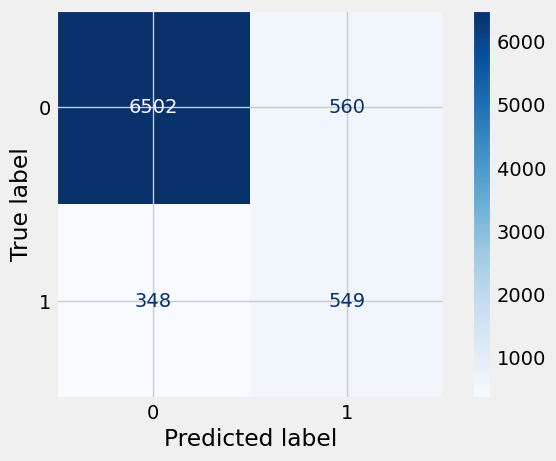

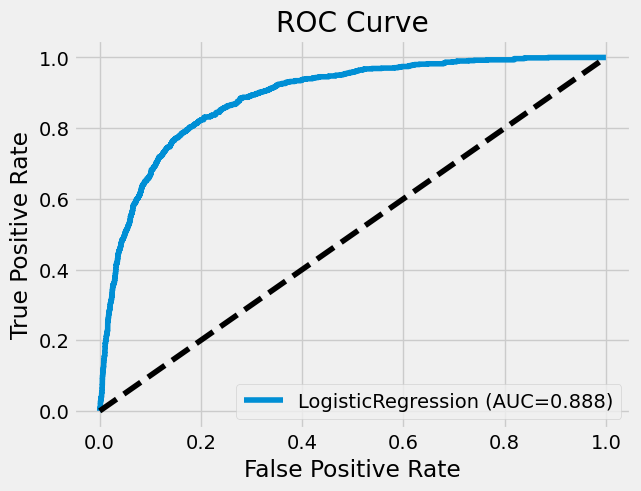

In [1279]:
X = dfFS.drop(columns=['y'])
y = dfFS['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

# Avaliação exemplo
evaluate_model(LogisticRegression(max_iter=1000),
               X_train_res, y_train_res, X_test, y_test)